In [1]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
alpha, beta, gamma, delta = (1.3,0.9,0.8,1.8)
x0, y0 = (0.44249296, 4.6280594)
# time_int = [0,3]

In [3]:
class LotkaVolterraSystem:
    def __init__(self, alpha, beta, delta, gamma, X):
        self.alpha, self.beta, self.delta, self.gamma = alpha, beta, delta, gamma
        self.X = X
        
    def model(X, t, alpha, beta, delta, gamma):
        x, y = X
        dxdt = x * (alpha - beta * y)
        dydt = y * (-delta + gamma * x)
        return np.array([dxdt, dydt])
    
    def solve(self, t):
        res = odeint(LotkaVolterraSystem.model, self.X, t, args = (self.alpha, self.beta, self.delta, self.gamma))
        return res

In [4]:
LV = LotkaVolterraSystem(alpha=alpha, beta=beta, delta=delta, gamma=gamma, X=[x0,y0])

In [5]:
t_phys_int = [0,3]
Np_phys = 10**3
t_phys = torch.linspace(t_phys_int[0], t_phys_int[1], Np_phys)

sol_phys = LV.solve(t=t_phys)
x_phys, y_phys = sol_phys.T
t_phys = t_phys.requires_grad_(True)

In [10]:
eps = 5e-3

def get_noisy_measurements(n, xi, yi, t, eps):
    bar_x = np.mean(xi)
    bar_y = np.mean(yi)
    
    assert n <= len(t)
    
    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]
#     print(len(t))
#     print(step)
#     print(indices)

    x = xi[indices]
    y = yi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    
    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)]), t[indices].clone().detach()

In [26]:
measurements, measurements_t = get_noisy_measurements(5, x_phys, y_phys, t_phys, 5e-2)

Text(0.5, 1.0, 'Test ')

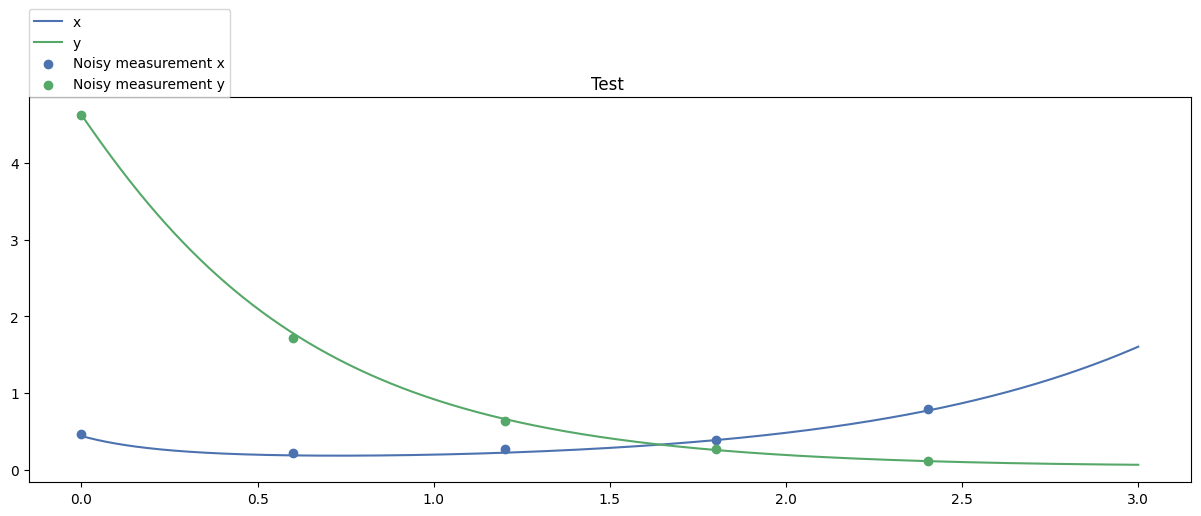

In [27]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_phys.detach().numpy(), x_phys, label='x')
ax.plot(t_phys.detach().numpy(), y_phys, label='y')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.legend(loc=(0,1))
ax.set_title('Test ')

In [28]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1e-2, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
u = U(1,2, [64,64])
u = u.to(device)

f = F(2,2, [16,16])
f = f.to(device)

[0/50001] Overall:56.674049377441406, Physics loss: 0.2866991460323334, Datapoint loss: 3.0262560844421387, Boundary loss: 12.076528549194336


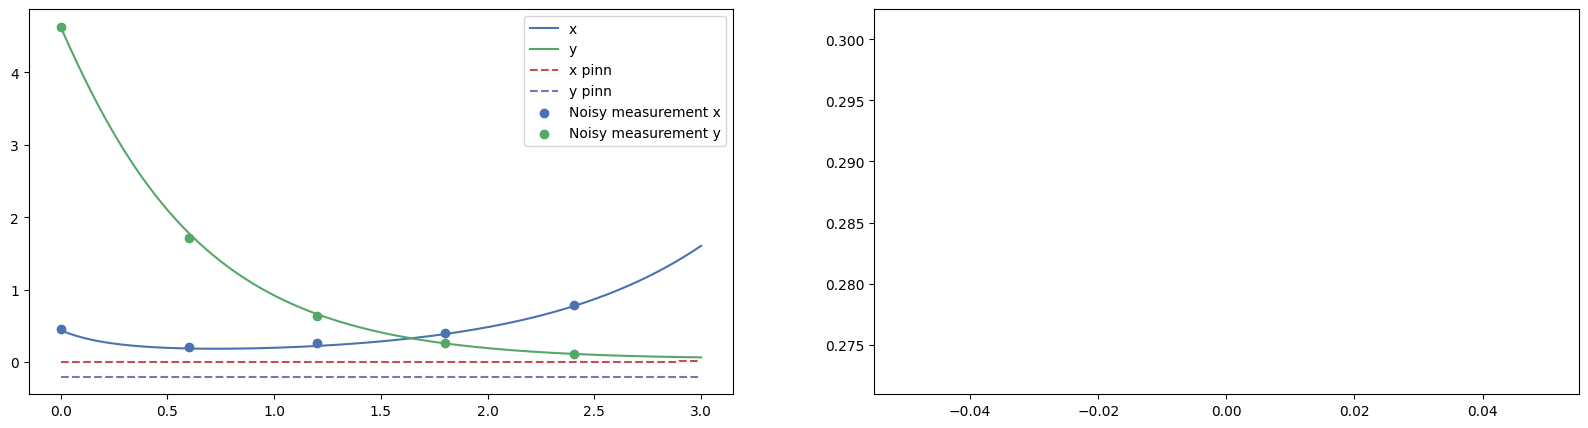

[4000/50001] Overall:0.11491350084543228, Physics loss: 0.00021238891349639744, Datapoint loss: 0.010085204616189003, Boundary loss: 0.0034420150332152843


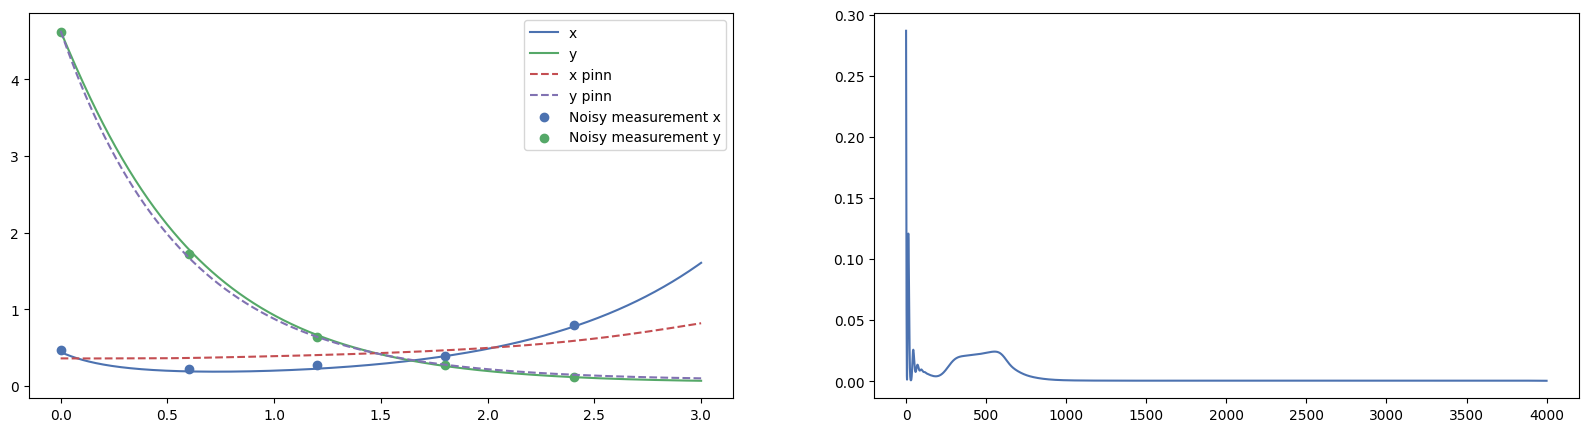

[8000/50001] Overall:0.00219160970300436, Physics loss: 2.791584165606764e-06, Datapoint loss: 0.00019554745813366026, Boundary loss: 9.655611938796937e-05


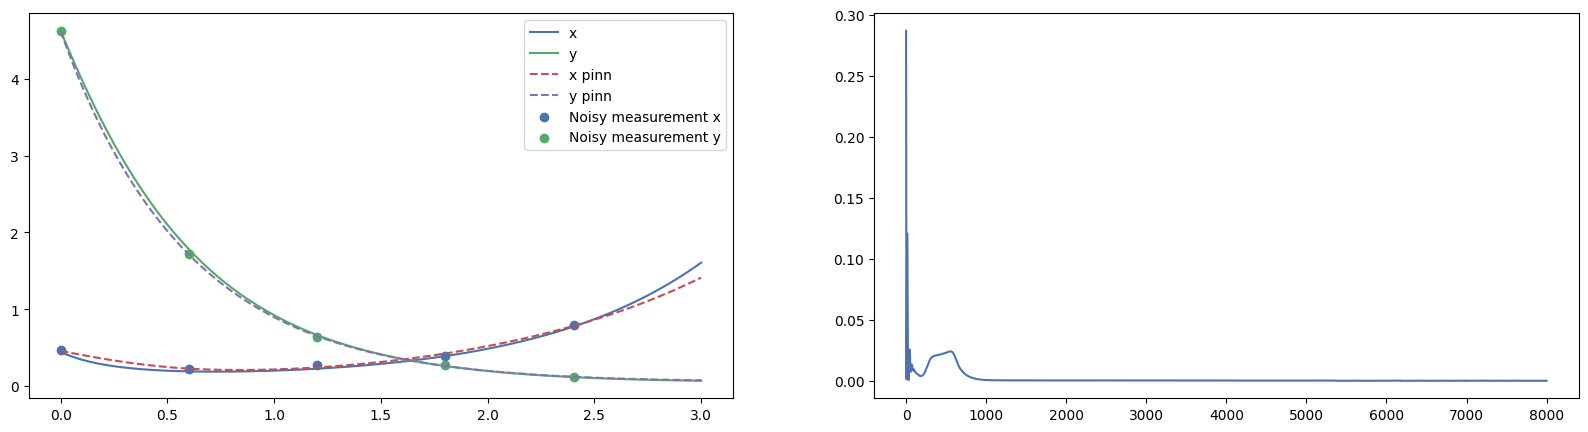

[12000/50001] Overall:0.001699201064184308, Physics loss: 1.0018450211646268e-06, Datapoint loss: 0.00015605414228048176, Boundary loss: 8.856737258611247e-05


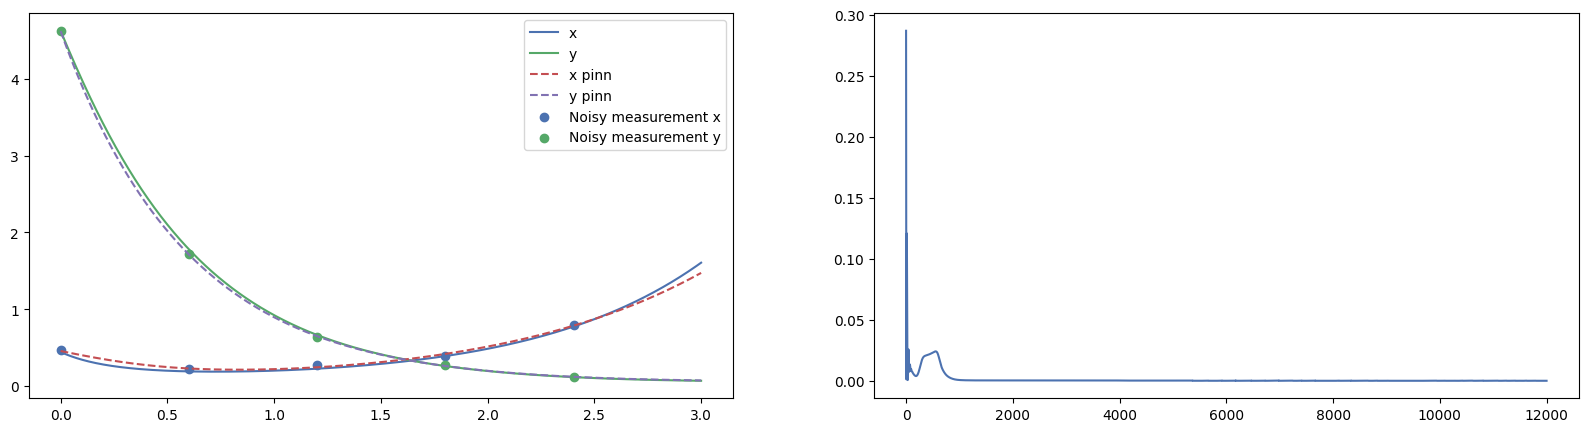

[16000/50001] Overall:0.0033894143998622894, Physics loss: 3.708291842485778e-05, Datapoint loss: 0.00014609331265091896, Boundary loss: 7.433552673319355e-05


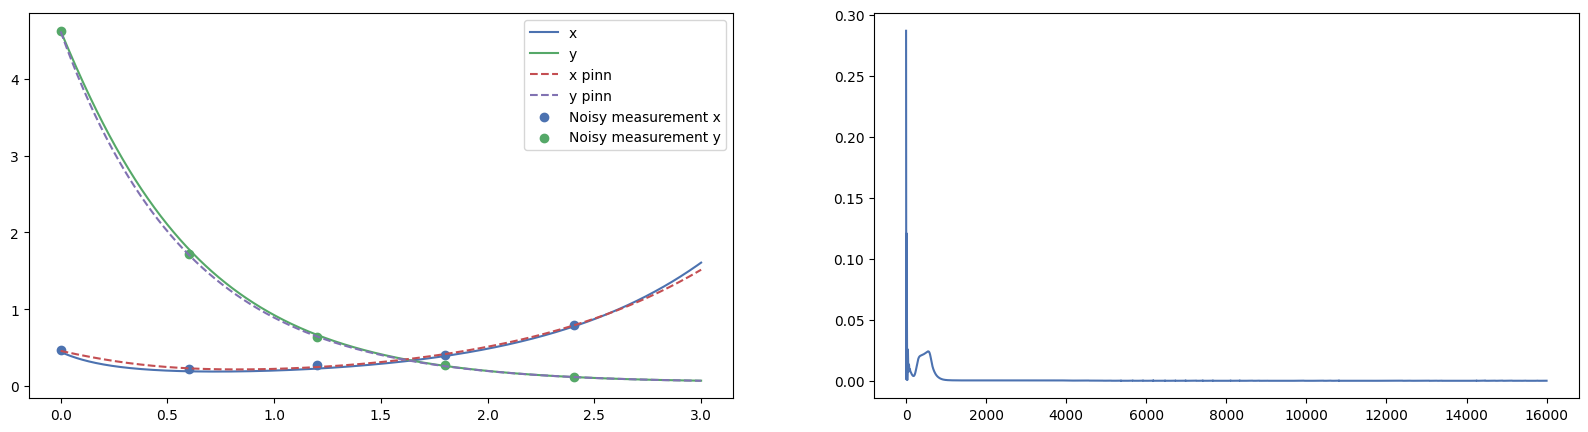

[20000/50001] Overall:0.0013407031074166298, Physics loss: 6.33605793609604e-07, Datapoint loss: 0.0001215185402543284, Boundary loss: 9.383745782542974e-05


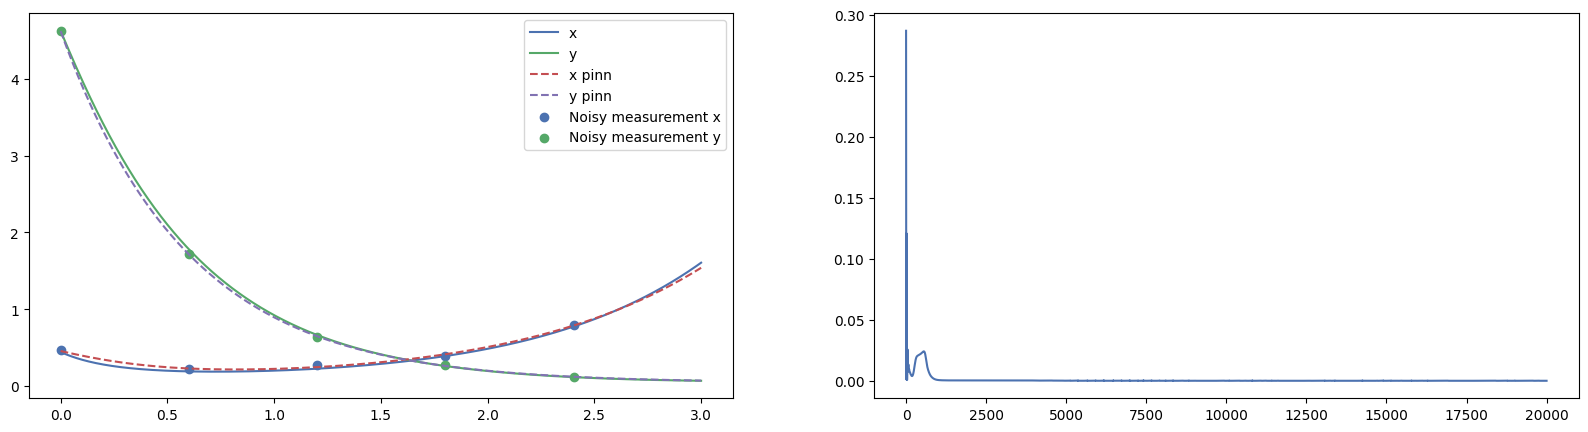

[24000/50001] Overall:0.0012308021541684866, Physics loss: 4.86186650050513e-07, Datapoint loss: 0.00011126594472443685, Boundary loss: 9.383334690937772e-05


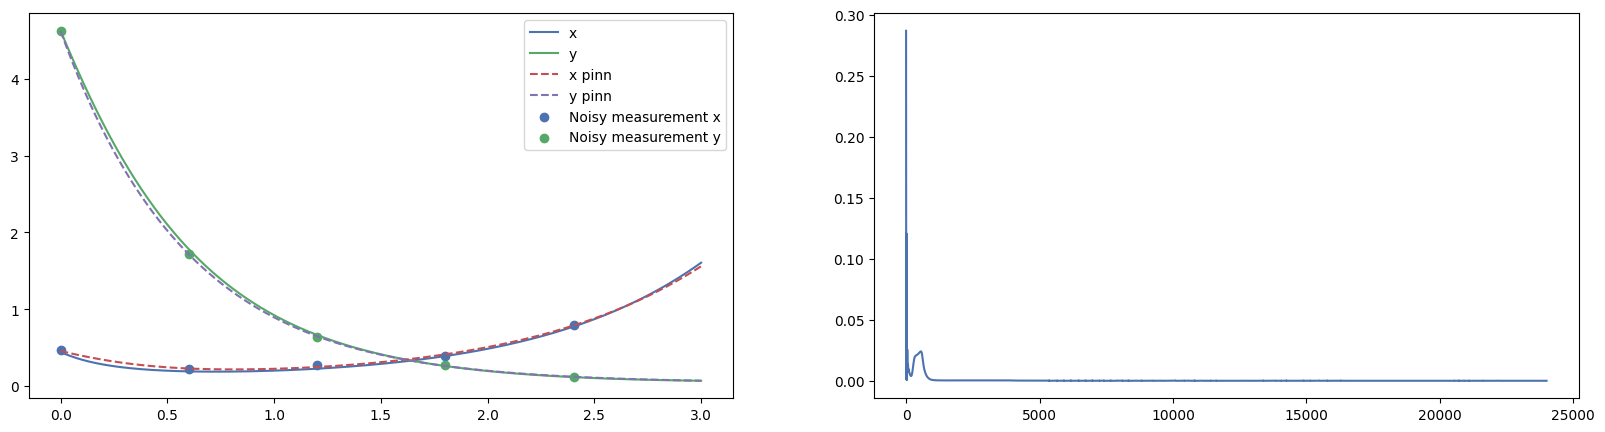

[28000/50001] Overall:0.0011438665678724647, Physics loss: 4.6630515271317563e-07, Datapoint loss: 0.00010241386917186901, Boundary loss: 9.641269571147859e-05


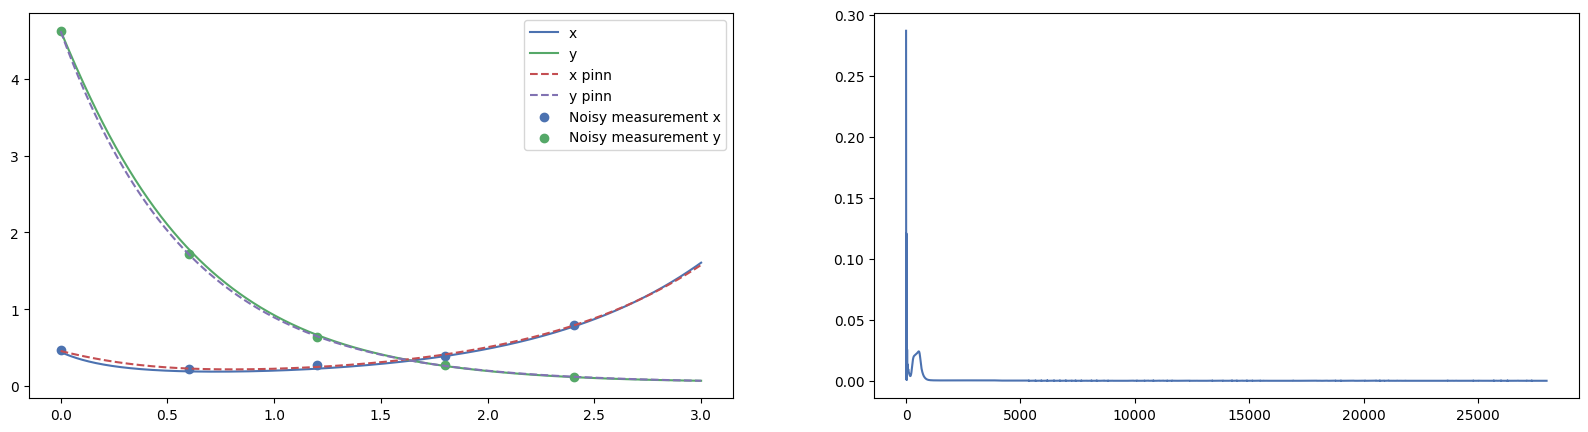

[32000/50001] Overall:0.0011925804428756237, Physics loss: 2.8581653168657795e-06, Datapoint loss: 9.598024189472198e-05, Boundary loss: 8.986969623947516e-05


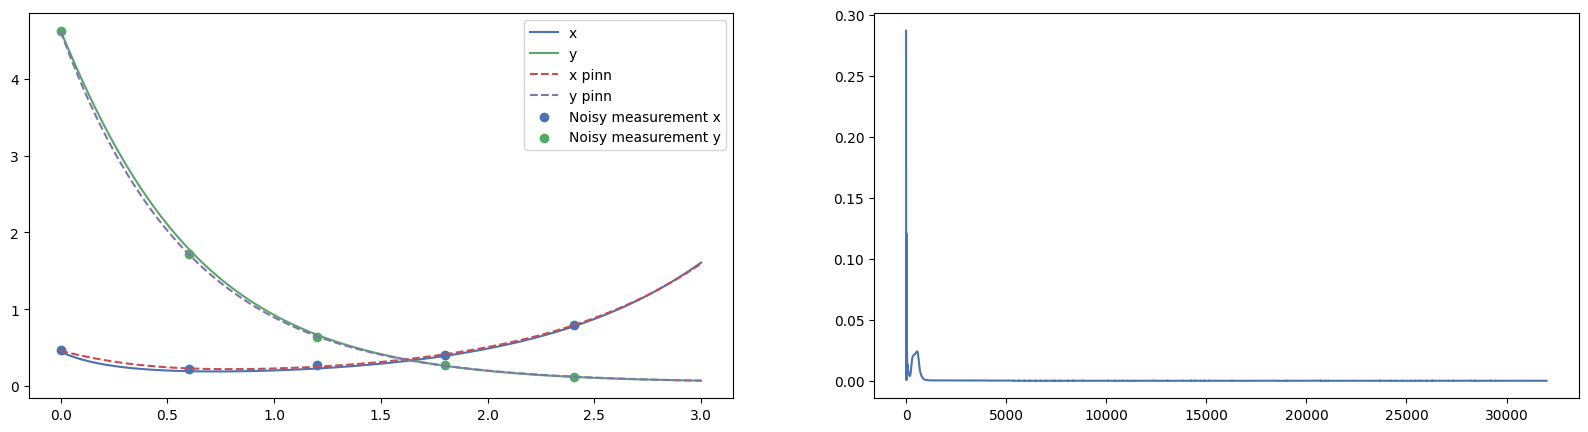

[36000/50001] Overall:0.001246161526069045, Physics loss: 5.131672878633253e-06, Datapoint loss: 8.59944339026697e-05, Boundary loss: 0.0001296335831284523


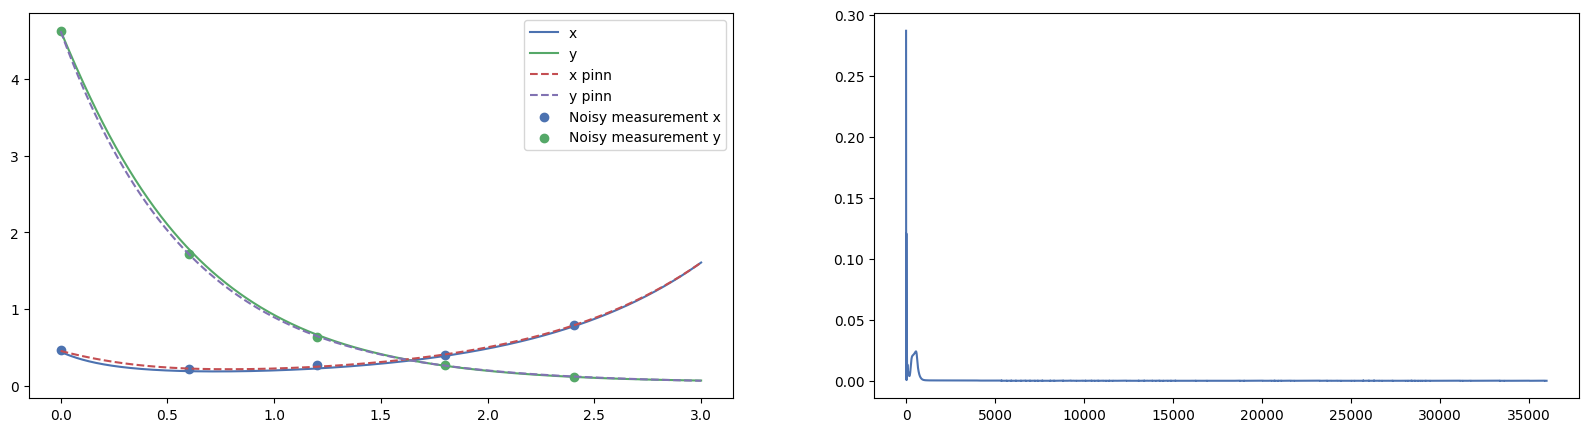

[40000/50001] Overall:0.0009265043190680444, Physics loss: 3.957551939492987e-07, Datapoint loss: 8.039146632654592e-05, Boundary loss: 0.00010280187416356057


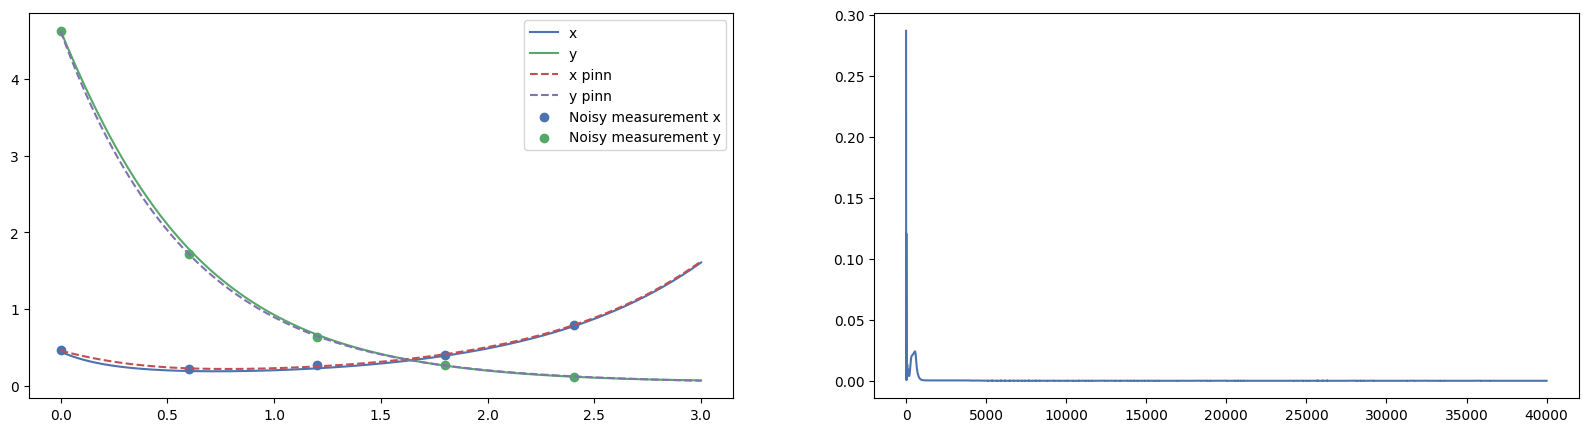

[44000/50001] Overall:0.0008643293986096978, Physics loss: 4.1371097836417903e-07, Datapoint loss: 7.452896534232423e-05, Boundary loss: 9.835419768933207e-05


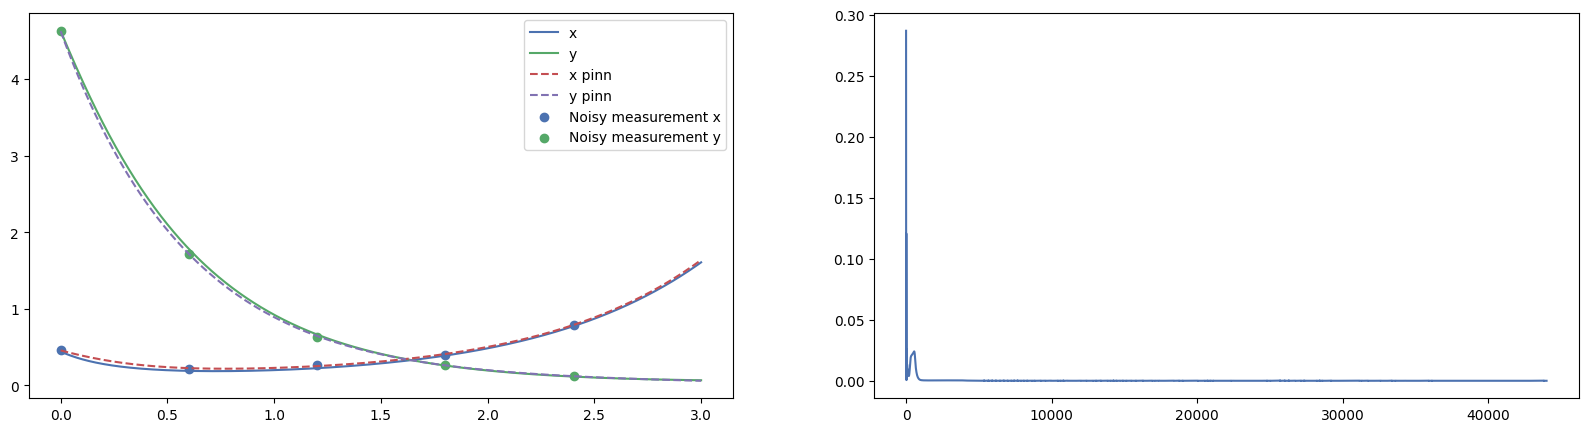

[48000/50001] Overall:0.0022866851650178432, Physics loss: 2.8203545298310928e-05, Datapoint loss: 8.294083090731874e-05, Boundary loss: 4.709949644166045e-05


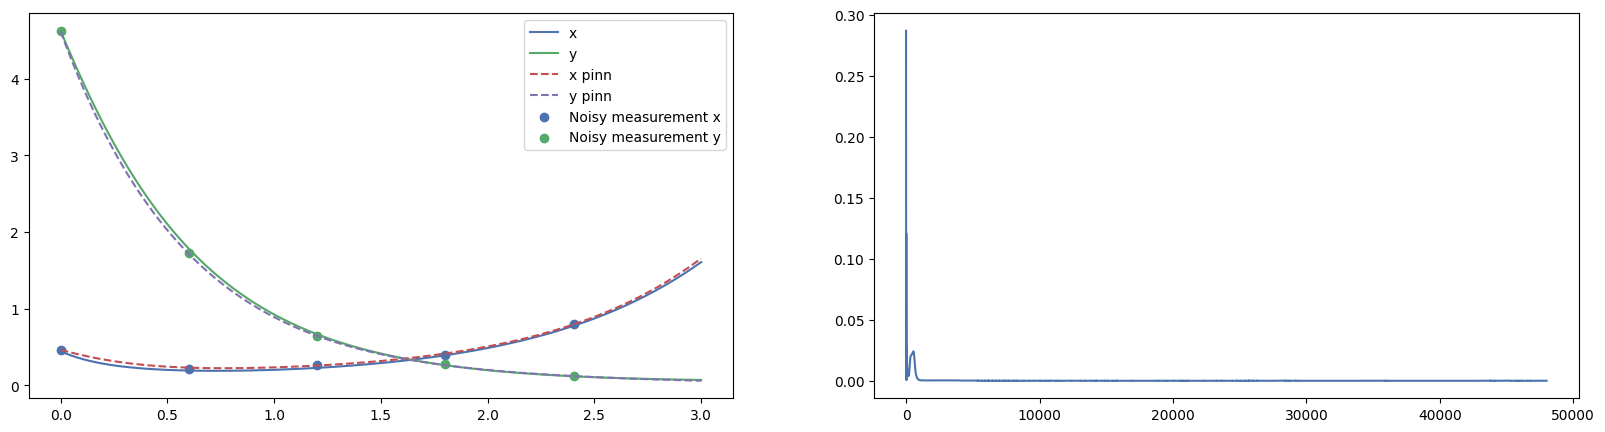

In [41]:
# Train
lr = 1e-3
optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
lambda1, lambda2, lambda3 = 1, 5e1, 1e1

phys_losses = []

total_itr = 50001
for i in range(total_itr):
    optimizer.zero_grad()
    
    # boundary loss -------
    x0, y0 = LV.X
    t_boundary = 0
    u_b = u(torch.Tensor([[t_boundary]]).to(device))
    loss1 = nn.MSELoss()(u_b, torch.Tensor([[LV.X[0],LV.X[1]]]).to(device)) # ensure the initial conditions
    

    # Physics loss -------
    
    phys_input = t_phys.to(device).reshape(-1,1)
    u_p = u(phys_input)
    x, y = u_p[:,0].reshape(-1,1), u_p[:,1].reshape(-1,1)
    dxdt = torch.autograd.grad(x, phys_input, torch.ones_like(x), create_graph=True)[0]
    dydt = torch.autograd.grad(y, phys_input, torch.ones_like(y), create_graph=True)[0]
    

    f_p = f(u_p.to(device)) # need to detach?
    f_a, f_b = f_p[:,0].reshape(-1,1), f_p[:,1].reshape(-1,1)

    dudt = torch.hstack([dxdt - LV.alpha * x + f_a, 
                         dydt + LV.delta * y + f_b])

    loss2 = nn.MSELoss()(dudt, torch.zeros_like(dudt))
    
    # Datapoint loss -------
    u_n = u(measurements_t.to(device).reshape(-1,1))
    loss3 = nn.MSELoss()(u_n, measurements.to(device).T)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    
    phys_losses.append(loss2.item())
    
    loss.backward()
    optimizer.step()
    
    if i% 4000 == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1,2, figsize=(20,5))
            ax[0].plot(t_phys.detach().cpu().numpy(), x_phys, label='x')
            ax[0].plot(t_phys.detach().cpu().numpy(), y_phys, label='y')
            print(f'[{i}/{total_itr}] Overall:{loss.item()}, Physics loss: {loss2.item()}, Datapoint loss: {loss3.item()}, Boundary loss: {loss1.item()}')
            
            # plot losses
            ax[1].plot(phys_losses, label='phys loss')
            
            # pinn
            u_p = u(t_phys.to(device).reshape(-1,1))
            x, y = u_p[:,0], u_p[:,1]
            ax[0].plot(t_phys.detach().cpu().numpy(), x.cpu(), label='x pinn', linestyle='--')
            ax[0].plot(t_phys.detach().cpu().numpy(), y.cpu(), label='y pinn', linestyle='--')
            ax[0].scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
            ax[0].scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
            ax[0].legend()
            plt.show()

In [79]:
def test_f(lv):
    with torch.no_grad():
        print(lv.beta, lv.gamma)
        phys_input = t_phys.to(device).reshape(-1,1)
        u_p = u(phys_input)
        fig, ax = plt.subplots(1, figsize=(10,5))
        # -\beta xy
        # + \gamma xy
        minus_beta_xy = -lv.beta * u_p[:,0] * u_p[:,1]
        gamma_xy = lv.gamma * u_p[:,0] * u_p[:,1]
        ax.plot(t_phys.detach().cpu().numpy(), minus_beta_xy.cpu(), label='True Unknown 1', color='red')
        ax.plot(t_phys.detach().cpu().numpy(), gamma_xy.cpu(), label='True Unknown 2', color='green')
        
        f_out = f(u_p.to(device))
        f_a, f_b = f_p[:,0], f_p[:,1]
        # Careful here. The network F is trained on the physics loss, which brings the unknown terms on one side of the equality.
        # This means that F is learning the negative values. Keep it in mind if the loss changes (e.g you bring the diff. operators on the other 
        # side rather than the unknowns)
        ax.plot(t_phys.detach().cpu().numpy(), -f_a.cpu(), label='Approximated F1', linestyle='--', color='red')
        ax.plot(t_phys.detach().cpu().numpy(), -f_b.cpu(), label='Approximated F1', linestyle='--', color='green')
        
        fig.legend()
        

0.9 0.8


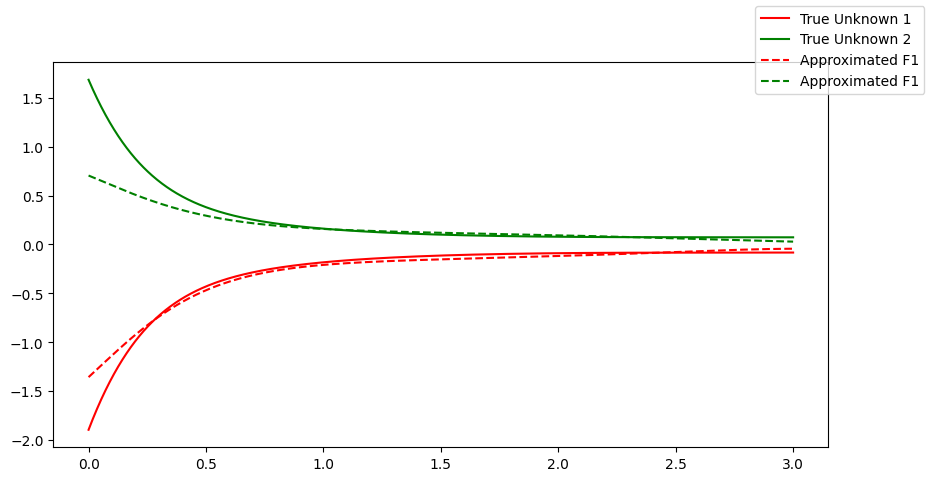

In [80]:
test_f(LV)